In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import types
import dask.array as da

import dask.array as da
import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage import * #S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import power_spectrum_custom, calculate_distance
from leakage.low_pass_filter import *
from leakage.uncertainties import *
from leakage.frequency_domain_padding import *

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.nanmean(x**2)), rounding)
rmse = lambda x, rounding=3:  np.round(np.sqrt(np.nanmean(x**2)), rounding)
dB = lambda x: 10*np.log10(x)

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios.sort()
scenarios

['Aghulas_20200203',
 'Aghulas_20200215',
 'Aghulas_20200227',
 'Aghulas_20200309',
 'Aghulas_20200322',
 'Aghulas_20200403',
 'Aghulas_20200415',
 'Aghulas_20200427',
 'Azores_20201127',
 'Barbedos_20201110',
 'Brasilia_20200321',
 'Brasilia_20200402',
 'Carrib_20231104',
 'Hawaii_20201106',
 'Iceland_20231107',
 'Scotland_20231109']

In [3]:
scenario = 'Aghulas_20200309'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6_800,
    PRF=4,
    grid_spacing=75,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=45,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = None,

    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= True
    )

In [6]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# # test.wdir_wrt_sensor = 0
# test.create_dataset()
test.create_beam_mask()
test.compute_scatt_eqv_backscatter()
test.compute_beam_pattern()
test.compute_leakage_velocity()
test.compute_leakage_velocity_estimate()
test.apply()

KeyboardInterrupt: 

In [5]:
test.data.nrcs.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

# ˆˆˆˆˆ

In [6]:
# Store
data_to_return = ['az', 'doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat', 'V_sigma', 'V_sigma_subscene',
                            'doppler_pulse_rg_subscene', 'doppler_pulse_rg_subscene_inverted',
                            'V_leakage_pulse_rg_subscene', 'V_leakage_pulse_rg_subscene_inverted',
                            'nrcs_scat_subscene', 'doppler_pulse_rg_inverted',
                            'V_leakage_pulse_rg_inverted', 'nrcs_scat_w_noise',
                            'nrcs_scat_subscene_w_noise']

storage_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/data/leakage/temp"
storage_file = f"{storage_dir}/test_{scenario}_v5.nc"

In [ ]:
# # Store
# # data[data_to_return] = data[data_to_return].chunk('auto').persist()
# test.data[data_to_return].chunk('auto').compute().to_netcdf(storage_file)

In [7]:
# Reload
test.data =  xr.open_dataset(storage_file)

## Misc

In [37]:

test.start_idx

45

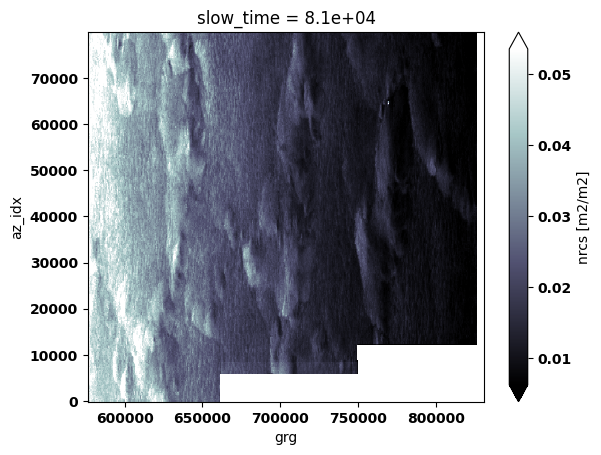

In [31]:
test.data.nrcs.isel(slow_time = 0).plot(robust = True, cmap = 'bone')
# test.S1_file.sigma0.sel(line = slice(0, 8000)).plot(robust = True, cmap = 'bone')

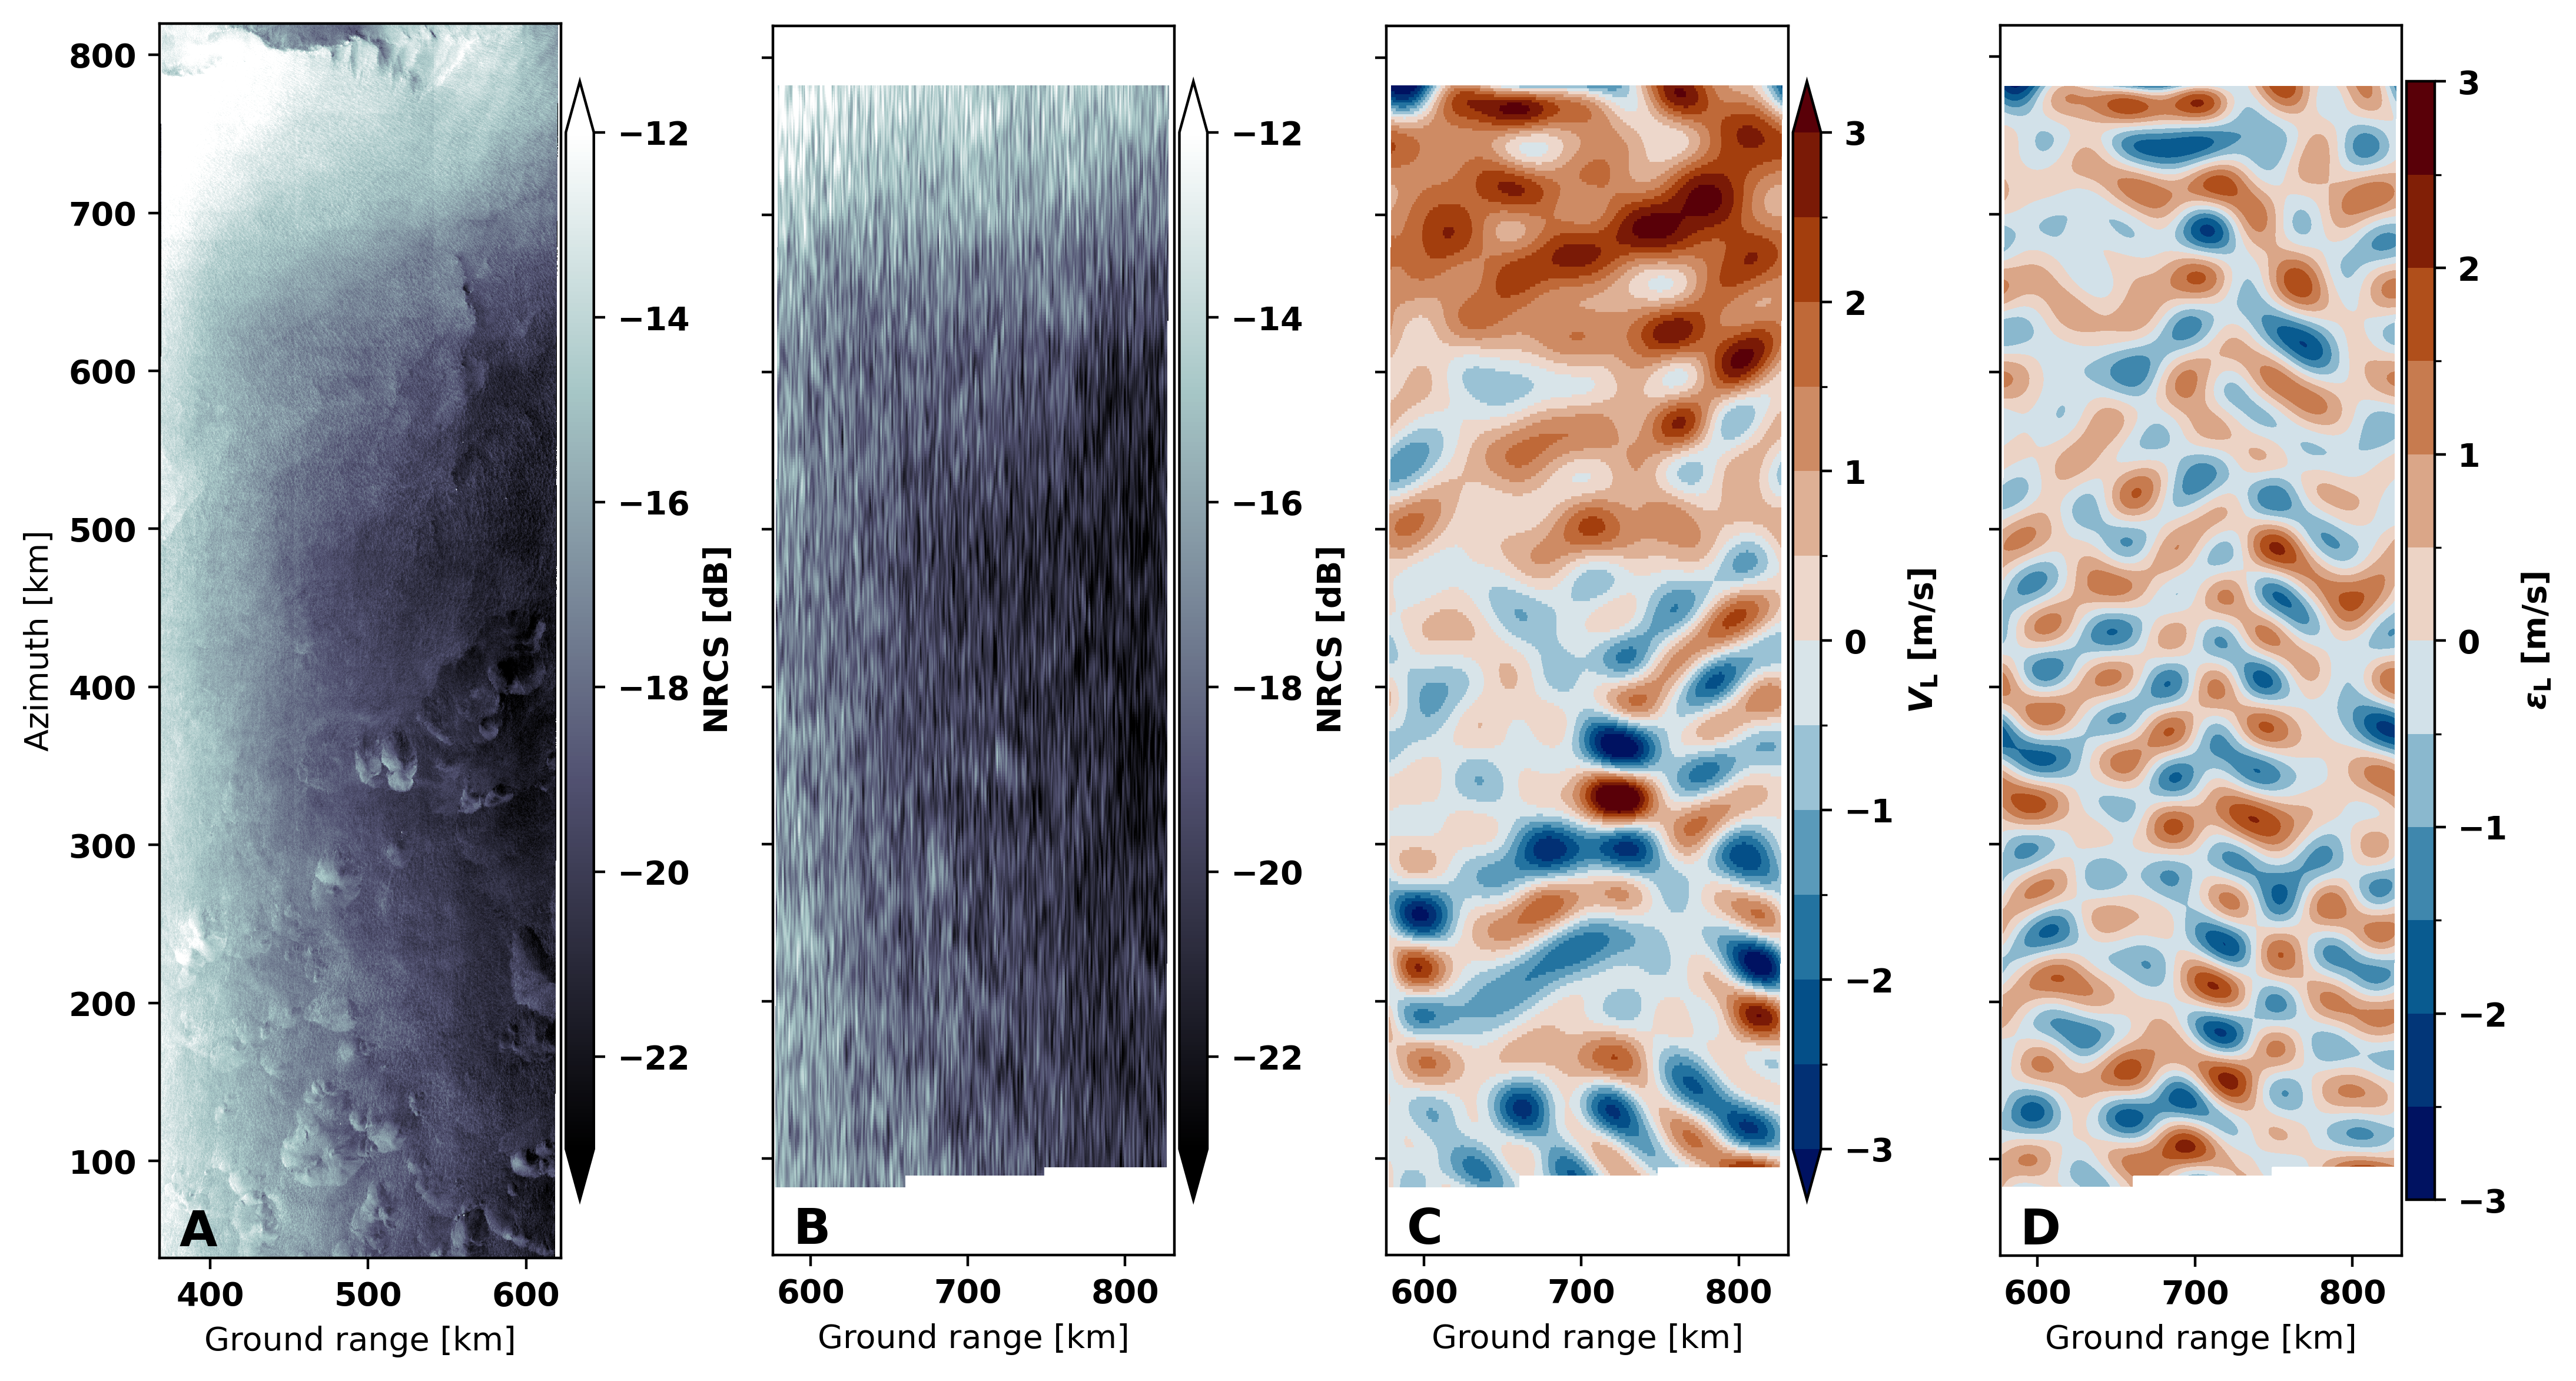

In [5]:
cbar_kwargs = {'shrink':0.8, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -4, 'vmax': 4, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 6; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (16, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)

LoS_comp = 1 # (1 / np.cos(test.data['elevation_angle'].mean(dim = 'az_idx')))

plot_cut = net_velocity_error / net_velocity_error

ver_max = (data_plot.az.max() + abs(data_plot.az.min())).values*1 / divide_by
ver_min = 0 #/ divide_by
grg_average = test.S1_file.ground_range_approx.mean(dim = 'line') / divide_by
hor_max = grg_average.max().values
hor_min = grg_average.min().values

# az_new = np.linspace(ver_min, ver_max, test.S1_file.sigma0.sizes['line'])
az_new = np.arange(test.S1_file.sigma0.sizes['line']) * test.grid_spacing / divide_by
grg_new = np.linspace(hor_min, hor_max, test.S1_file.sigma0.sizes['sample'])
nrcs_original = 10*np.log10(test.S1_file.drop_vars('pol').assign_coords(line=('line', az_new), sample = ('sample', grg_new)).sigma0)

nrcs_original.plot(ax= axes[*axes_indexes[0]], 
                   **{'cmap': 'bone', **plot_kwargs_nrcs},
                   cbar_kwargs = {'label':r'$\mathrm{NRCS\ [dB]}$', **cbar_kwargs})

(10*np.log10(data_plot.nrcs_scat_w_noise)).T.plot(ax= axes[*axes_indexes[1]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs_nrcs},
                                          cbar_kwargs = {'label':r'$\mathrm{NRCS\ [dB]}$', **cbar_kwargs})
# (10*np.log10(data_plot.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
#                                                   **{'cmap': 'bone', **plot_kwargs},
#                                                   cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
# (data_plot.V_sigma_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[1]],#[0,2], 
#                                              **{**plot_leakage_kwargs, **plot_kwargs},
#                                              cbar_kwargs = {'label':r'$\sigma_{\mathrm{pp}} + V_{\mathrm{L}}\ \mathrm{[m/s]}$', **cbar_kwargs})
(data_plot.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[2]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(net_leakage  * LoS_comp).T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(net_velocity_error * LoS_comp).T.plot.contourf(ax= axes[*axes_indexes[5]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})

res = test.resolution_product/1000
titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [6]:
func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)
func_rmse(net_leakage)

0.734

In [7]:
test.velocity_error / np.sqrt(test.grg_N*test.slow_time_N)

(4.323, 4.357)

In [8]:
func_rmse(test.data.V_sigma_subscene * plot_cut), func_rmse(net_velocity_error)

1.205

In [9]:
func_rmse(test.data.V_leakage_pulse_rg_subscene)

4.18

In [11]:
data_dir_dca = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
files_dca = glob.glob(f"{data_dir_dca+scenario}/*.nc")
# files_dca = [file for file in files_dca if 'S1A' in file]
files_dca
add_dca_to_leakage_class(test, files_dca=files_dca)

In [12]:
t = 1 - np.nansum(net_velocity_error**2) / np.nansum((test.data.V_dca_pulse_rg_subscene - test.data.V_dca_pulse_rg_subscene.mean())**2)

In [13]:
snr = to_decibel(signal_2_noise_ratio(signal=test.data.V_dca_pulse_rg_subscene, noise=net_leakage,))

AttributeError: 'Dataset' object has no attribute 'V_dca_pulse_rg_subscene'

In [14]:
np.nansum(((test.data.V_dca_pulse_rg_subscene - test.data.V_dca_pulse_rg_subscene.mean())**2).compute())

NameError: name 'snr' is not defined

In [43]:
t#.compute()

-59.90188980102539

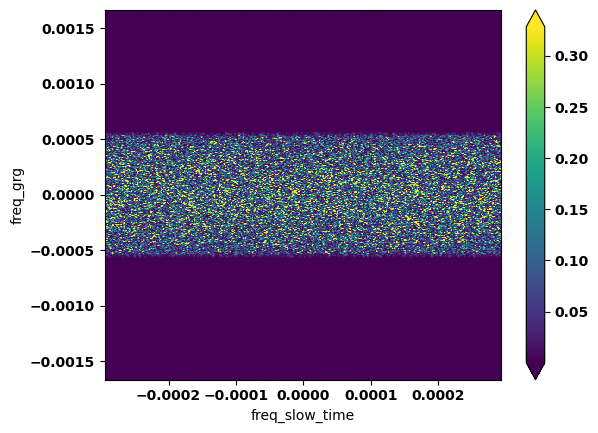

In [18]:
test.data.V_dca_pulse_rg_subscene.T.plot()

## Moving average vs Fourier filter

(-30.0, 0.0)

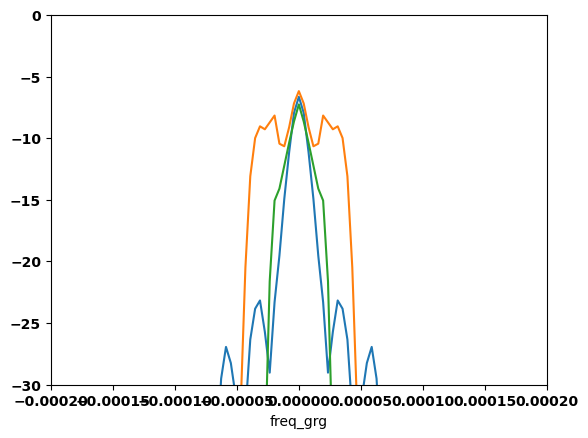

In [19]:
scaling = 'spectrum'

# t = test.data.V_pp.persist().rolling(grg=test.grg_N//2, slow_time=test.slow_time_N//2, center=True).mean()
t = test.data.V_pp.persist().rolling(grg=147, slow_time=6, center=True).mean()
tt = power_spectrum_custom(t.chunk({**t.sizes}), scaling = scaling)
ttt = 10*np.log10(tt.sel(freq_slow_time = slice(-0.00003, 0.00003)).mean(axis = 1))
tttt = xr.where((ttt - ttt.max()) < -3, 1, np.nan)

fs_x=1/test.grid_spacing
fs_y=1/test.stride
l = low_pass_filter_2D(test.data.V_pp, cutoff_frequency=1/25_000, fs_x=fs_x, fs_y=fs_y, fill_nans=True, window = 'hann')
m = low_pass_filter_2D(test.data.V_pp, cutoff_frequency=1/50_000, fs_x=fs_x, fs_y=fs_y, fill_nans=True, window = 'hann')

dimensions = [*test.data.V_pp.sizes]
for dimension in dimensions:
    l[dimension] = test.data.V_pp[dimension]
    m[dimension] = test.data.V_pp[dimension]

ll = power_spectrum_custom(l.chunk({**l.sizes}), scaling = scaling)
mm = power_spectrum_custom(m.chunk({**m.sizes}), scaling = scaling)
lll = 10*np.log10(ll.sel(freq_slow_time = slice(-0.00003, 0.00003)).mean(axis = 1))
mmm = 10*np.log10(mm.sel(freq_slow_time = slice(-0.00003, 0.00003)).mean(axis = 1))

ttt.plot(), lll.plot(), mmm.plot()
plt.xlim([-0.0002, 0.0002])
plt.ylim([-30, 0])


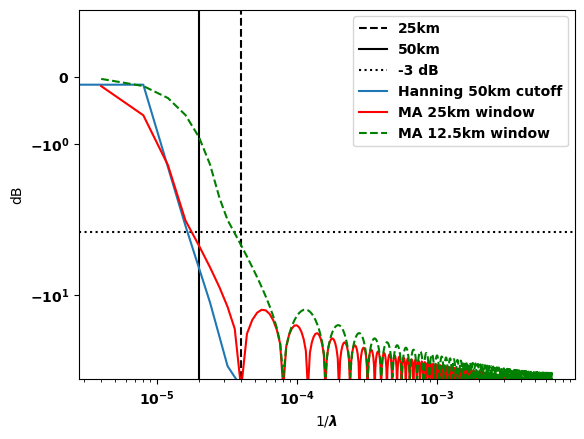

In [20]:
from scipy.signal import firwin

def intensity(magnitude):
    N = len(magnitude)
    I = (abs(magnitude) / N)**2
    return I

start = 0
stop = 250000
fs = 1/75
dx = 1/fs
N1 = (12500 * fs) // 1
N2 = (25000 * fs) // 1
f_delta = 1 / (stop-start)
f_max = 1/(dx*2)
f_min = 0

f = np.arange(f_min, f_max, f_delta)
omega = 2 * np.pi * f / fs
N = int(len(f))

H1 = 10*np.log10((1/ N1 * abs(np.sin(omega*N1 / 2) / np.sin(omega/2)))**2)
H2 = 10*np.log10((1/ N2 * abs(np.sin(omega*N2 / 2) / np.sin(omega/2)))**2)

w = N*firwin(numtaps = N, cutoff=1/50000, fs=fs, pass_zero=True, window='hann') 

W = np.fft.fftshift(intensity(np.fft.fft(w)))
f_w = np.fft.fftshift(np.fft.fftfreq(n = int(N), d = dx))

plt.axvline(1/25000, c = 'k', ls = '--', label = '25km')
plt.axvline(1/50000, c = 'k', ls = '-',label = '50km')
plt.axhline(-3, c = 'k', ls = ':',label = '-3 dB')

plt.plot(f_w, 10*np.log10(W), label = 'Hanning 50km cutoff')
plt.plot(f, H2, c = 'r', ls = '-', label = 'MA 25km window')
plt.plot(f, H1, c = 'g', ls = '--', label = 'MA 12.5km window')
plt.legend()
plt.xscale('log')
plt.ylim([-50, 1])
plt.ylabel('dB')
plt.xlabel(r'1/$\lambda$')
plt.yscale('symlog')

## Coherence check

In [ ]:
wavenumber = 2 * np.pi / test.Lambda

# -- calculates average azimuthal beam standard deviation within -3 dB 
beam_db = 10 * np.log10(test.data.beam)
beam_3dB = xr.where((beam_db- beam_db.max(dim = 'az_idx'))< -3, np.nan, 1)*test.data.az_angle_wrt_boresight
sigma_az_angle = beam_3dB.std(dim = 'az_idx').mean().values*1

T_corr_Doppler = 1 / (np.sqrt(2) * wavenumber * test.vx_sat * sigma_az_angle) # equation 7 from Rodriguez et al., (2018)
T_pp = test.T_pp # intra pulse-pair pulse separation time, Hoogeboom et al., (2018)
U = 6 # Average wind speed assumed of 6 m/s
T_corr_surface = 3.29 * test.Lambda / U

In [ ]:
N_T_pp = 7  #-5
T_pps = np.logspace(-6, -3, N_T_pp)
SNRs = 2**np.arange(0, 14, 2)
N_SNR = len(SNRs)

input_T_pp = np.broadcast_to(T_pps, (N_SNR, N_T_pp)).T.ravel()
input_SNR = np.broadcast_to(SNRs, (N_T_pp, N_SNR)).ravel()
_ , gammas = phase_uncertainty_rodriguez2018(
    T_pp = input_T_pp,
    T_corr_surface =  T_corr_surface,
    T_corr_Doppler =  T_corr_Doppler,
    SNR =  input_SNR,
    Lambda =  test.Lambda,
    N_L = 1)

phase_errors = np.array([phase_error_generator(gamma, n_samples = 10000, random_state=test.random_state) for gamma in gammas])
velocity_errors = np.std(phase_errors / 2 / wavenumber / test.T_pp, axis=1)

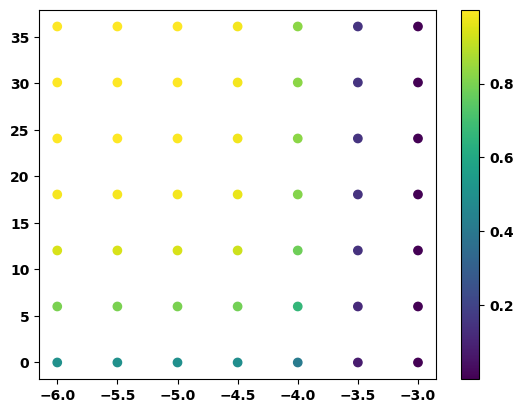

In [ ]:
plt.scatter(np.log10(input_T_pp), dB(input_SNR), c = gammas); plt.colorbar()

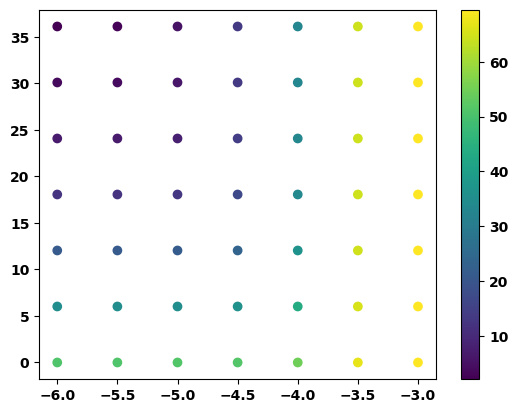

In [ ]:
plt.scatter(np.log10(input_T_pp), dB(input_SNR), c = velocity_errors); plt.colorbar()